<a href="https://colab.research.google.com/github/LarryAruna/Amazon-Product/blob/main/TopicModel_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Text Classification for Marketing Analytics Final Project

## Introduction

Topic modeling to deliver marketing and product insights for a popular clothing and/or shoe company, Nike. The purpose of this project is to do some topic modeling (Un-supervised Machine Learning) to cluster out the comments that people have about NIKE SHOES.  

To do this we will iterate through both the product and review data.
First we will inspect the product metadata to find top product ASINS, then we'll go through the review data to pull the matching reviews for those ASINS.

## **⚡️ Preparation:** Get the data files

Before starting we will need to copy the data files up to your Google Drive account. The file was formated Json file

## Mount Google Drive

After uploading the files to your Google Drive, mount Drive in order to allow Colab to access the files.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

Need to import json package becuase the file was formated in Json files

In [1]:
import gzip
import json
import os
import pandas as pd
try:
  from bertopic import BERTopic
except:
  !pip install bertopic[all]
  os.kill(os.getpid(), 9)

In [2]:
import itertools

# This process is going to be a two step process:
1. Go through the amazon product category for "clothing, shoes and Jewelery file and extract out matching product by their ASIN

2. Go through the review data and parse out the matching reviews by ASIN

In [3]:
# Extract out matching product by their ASIN
count=0
allproducts = {}
with gzip.open("drive/MyDrive/meta_Clothing_Shoes_and_Jewelry.jsonl.gz") as products:
    for product in products:
        data = json.loads(product)
        count +=1
        if count % 100000 == 0:
          print(count)
        aproduct = eval(product)
        allproducts[aproduct['asin']] = aproduct



100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000


In [4]:
len(allproducts)

1503384

# Explore the product data to see what categories are commom in the data

In [5]:
allcategories = {}
count = 0

for aproduct in allproducts:
    #creating a counter to know our progress in processing the entire catalog
    count += 1
    if count % 100000 == 0:
        #we now know there are 1.5 million products, so we can build a counter
        #that tells how our processing is going. When the counter reaches one
        #we're done!
        print(count/1503384)
    #setting a dict up with just one product, so we can inspect and ref it
    aproduct = allproducts[aproduct]
    #creating a dictionary entry for each product category
    #also counting the occurances of each category
    if 'categories' in aproduct:
        for categories in aproduct['categories']:
            for acategory in categories:
                if acategory in allcategories:
                    allcategories[acategory] += 1
                if acategory not in allcategories:
                    allcategories[acategory] = 1

0.06651660520532346
0.13303321041064692
0.19954981561597038
0.26606642082129384
0.33258302602661727
0.39909963123194075
0.4656162364372642
0.5321328416425877
0.5986494468479111
0.6651660520532345
0.7316826572585581
0.7981992624638815
0.8647158676692049
0.9312324728745284
0.9977490780798518


In [6]:
sortedlist = []
for acategory in allcategories:
  sortedlist.append((allcategories[acategory],acategory))

sortedlist = sorted(sortedlist, reverse=True)

for item in range(0,50):
  print(sortedlist[item])

(3429257, 'Clothing, Shoes & Jewelry')
(1086181, 'Women')
(617092, 'Clothing')
(541681, 'Men')
(537761, 'Novelty, Costumes & More')
(432653, 'Shoes')
(339900, 'Novelty')
(268065, 'Shoes & Accessories: International Shipping Available')
(255454, 'Jewelry')
(174962, 'Accessories')
(97095, 'Girls')
(93596, 'Tops & Tees')
(87688, 'Dresses')
(84549, 'T-Shirts')
(82063, 'Boots')
(80302, 'Shirts')
(79897, 'Sandals')
(79545, 'Watches')
(77684, 'Boys')
(73507, 'Jewelry: International Shipping Available')
(72372, 'Athletic')
(71414, 'Wrist Watches')
(70335, 'Sports & Outdoors')
(59763, 'Petite')
(58350, 'Fashion')
(53826, 'Costumes & Accessories')
(53021, 'Earrings')
(51728, 'Baby')
(50943, 'Comfort Shoes')
(50662, 'Casual')
(50357, 'Boot Shop')
(50124, 'C')
(49599, 'Active')
(49491, 'Band & Music Fan')
(46004, 'New Arrivals')
(43722, 'Necklaces & Pendants')
(43410, 'Intimates')
(43100, 'S')
(41709, 'Lingerie, Sleep & Lounge')
(41542, 'Handbags & Wallets')
(41400, 'Rings')
(40832, "Women's Luxur

In [7]:
allcategories['Nike']

8327

## 👟 Discovering the Nike ASINs


Since not all products have a brand value set, we will extract ASINs for products with "Nike" in the categories. We will ignore the title case of instances of Nike to be sure we catch things like NIKE and nike.



### Build a list of Nike ASINs

Build a list of Nike ASINs

In [8]:
asins = []
with gzip.open("drive/MyDrive/meta_Clothing_Shoes_and_Jewelry.jsonl.gz") as products:
    for product in products:
        data = json.loads(product)
        categories = []
        for category_list in data.get("categories", []):
            _catlist = []
            for item in category_list:
                _catlist.append(item.lower())
            categories += _catlist
        if "nike" in categories:
            asins.append(data["asin"])

The length of `asins` will tell us how many we have:

In [9]:
len(asins)

8327

Inspect a few to see that things look as expected:

In [10]:
asins[:5]

['B0000V9K32', 'B0000V9K3W', 'B0000V9K46', 'B0000V9KNM', 'B0000V9KRI']

# Read in Meta Clothing based on Nike and ASIN and extract a list of ASINs with Sale Ranks

In [11]:
sales_ranks = {}

with gzip.open("drive/MyDrive/meta_Clothing_Shoes_and_Jewelry.jsonl.gz") as products:
    for i, product in enumerate(products):
        #Uncomment these lines to reduce the debug cycle for troubleshooting only !!!
        #if i > 10000: # 10000 because we don't hit Nike products for a while
        #    break
        data = json.loads(product)
        categories = []
        for category_list in data.get("categories", []):
            _catlist = []
            for item in category_list:
                if item.strip() != item:
                    print(category_list)
                _catlist.append(item.lower())
            categories += _catlist
        if "nike" in categories:
            if data.get("salesRank"):
                # TODO: Complete the extraction of sales rank and populate
                # that information into the sales_ranks dictionary, keyed
                # by the asin value.
                asin = data.get("asin")
                sales_rank = data["salesRank"]
                sales_ranks[asin] = next(iter(sales_rank.values())) # values -> iterable -> next (returns 1st value)


Check the length of `sales_rank`

In [12]:
len(sales_ranks)

7962

Inspect the first few items of `sales_rank`

In [13]:
dict(list(sales_ranks.items())[:5])

{'B0000V9K32': 67039,
 'B0000V9K3W': 102054,
 'B0000V9K46': 116131,
 'B0000V9KNM': 105485,
 'B0000V9KRI': 88704}

In [14]:
import operator
ordered_asin_ranks = sorted(sales_ranks.items(), key=operator.itemgetter(1))
ordered_asin_ranks[0]

('B00EQBFL62', 179)

## 📊 Plot a histogram

You have now gathered all the product ranking data. For analysis, however, we really just want to look at the top ranking products. How many products, you ask? A histogram will help us to make that decision.

### 🐍 The Seaborn library

[Seaborn](https://seaborn.pydata.org/) is a statistical data visualization library that makes quick work of some common types of visualizations. Here we see that it makes histogram plotting almost trivial.

The histogram (a.k.a. [distplot](https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn.displot) with `kind` set to "hist", the default) in seaborn simply takes a list of values. In this case, we want to plot the sales ranks, which is just the values list of the sale_ranks dictionary:

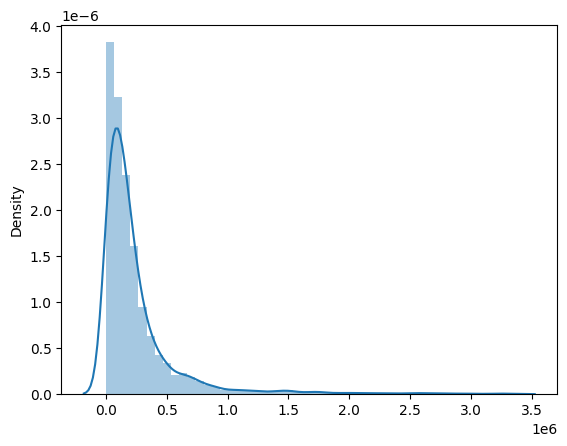

In [15]:
import seaborn as sns
plot = sns.distplot(list(sales_ranks.values()))

You can see here that there is quite a long tail of low-ranking products, i.e. large values going to the right on the x-axis. Some of these rankings are low enough that Seaborn has plotted at a scale of 1 x 10^6. It looks like our lowest ranking product ranks as about the 3.5 millionth best selling product in it's category!

We can verify this simply by looking at the last item of the ordered list we produced above:

In [16]:
ordered_asin_ranks[-1]

('B000AYI6FC', 3341111)

At a glance, we can see that the bulk of our ranked products, however, fall into the range of 0 to 3000, where 3000 is indicated as 0.5 x 1x10^6.

For purposes of analysis, then, let's create a filtered subset of the list that contains only ASINs of products with a sales rank of 3000 or better.

In [17]:
best_asins = [asin for asin, rank in sales_ranks.items() if rank <= 3000]

### Inspect a few items:

In [18]:
best_asins[:3]

['B0001LGWEQ', 'B000G42Z2Q', 'B000RDFRIK']

## Finalizing your data prep

we want the product reviews so that we can discover interesting things such as what are customers saying about the best selling products.

Now that we've prepared a set of ASINs of products worth analyzing, we will do the work of collecting their reviews.

The code block below sets  up to iterate the review data.

In order to collect the reviews into a useful data structure, we will create a concept of a key that is made up of the asin.reviewerID. Constructing this ID might look something like this, given `review` as the data structure of a single review:




In [19]:
top_reviews = {}
from tqdm import tqdm
with gzip.open("drive/MyDrive/reviews_Clothing_Shoes_and_Jewelry.json.gz") as reviews:
    for i, review in tqdm(enumerate(reviews)):
        review = json.loads(review)
        # print(review)
        # REMEMBER to remove this break once you have things working!!!
        # if i > 50000: # it takes a while to hit any Nike products in the data
        #     break

        _id = "%s.%s" % (review["asin"], review["reviewerID"])
        # print(review['asin'], review['asin'] in best_asins)
        if review['asin'] in best_asins:
          top_reviews[_id] = review

        # TODO: if the asin is in best_asins, add the review to top_reviews
        #       keyed by the newly constructed _id

5748920it [02:21, 40504.04it/s]


### Check the length of the resulting review set

In [20]:
len(top_reviews)

3549

In [21]:
top_reviews

{'B0001LGWEQ.A2AA85SKEXW87N': {'reviewerID': 'A2AA85SKEXW87N',
  'asin': 'B0001LGWEQ',
  'reviewerName': 'Joe',
  'helpful': [0, 0],
  'reviewText': "I've had this watch for over a year now and wear it daily. I love it and the features it provides.",
  'overall': 5.0,
  'summary': 'Nike Watch',
  'unixReviewTime': 1293408000,
  'reviewTime': '12 27, 2010'},
 'B000G42Z2Q.A32FW23QEMIW6F': {'reviewerID': 'A32FW23QEMIW6F',
  'asin': 'B000G42Z2Q',
  'reviewerName': 'Adam',
  'helpful': [1, 2],
  'reviewText': "Although I'm rarely a fan of Nike, I bought this pair to try it out and i absolutely liked it. Very suitable for causal wear, but I'm not sure how good of a running pair this one is. I got the dark grey color with florescent green stripes.Overall very cool pair",
  'overall': 3.0,
  'summary': 'Nice design by Nike',
  'unixReviewTime': 1367366400,
  'reviewTime': '05 1, 2013'},
 'B000G42Z2Q.A3L787MR2AI6N': {'reviewerID': 'A3L787MR2AI6N',
  'asin': 'B000G42Z2Q',
  'reviewerName': 'Adri

In [22]:
with open("drive/MyDrive/MSDS_Lab1_TopReviews.jsonl", "w") as top_reviews_file:
    for k, v in top_reviews.items():
        review = json.dumps(v)
        top_reviews_file.write(f"{review}\n")

In [23]:
texts = []
with open("drive/MyDrive/MSDS_Lab1_TopReviews.jsonl") as top_reviews_file:
    for review in top_reviews_file:
        data = json.loads(review)
        texts.append(data["reviewText"])

In [24]:
len(texts)

3549

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

#for text cleaning / preprocessing
import string, re
import nltk
#nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

#for data analysis and modeling
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn import decomposition

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Preprocess the Text Data

# Remove Stopwords

In [26]:
# Remove Stopwords
import nltk
nltk.download('stopwords')
def remove_stopwords(tokens):
  stop_words = set(stopwords.words('english'))
  filtered_tokens =[word for word in tokens if word not in stop_words]
  return filtered_tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
Cleaned_stop_data = remove_stopwords(texts)

In [28]:
len(Cleaned_stop_data)

3549

# Vosaulize the text values.

In [ ]:
Cleaned_stop_data

["I've had this watch for over a year now and wear it daily. I love it and the features it provides.",
 "Although I'm rarely a fan of Nike, I bought this pair to try it out and i absolutely liked it. Very suitable for causal wear, but I'm not sure how good of a running pair this one is. I got the dark grey color with florescent green stripes.Overall very cool pair",
 'i love this shoes  great price good quality',
 'I ordered this just before my last Europe trip. I ordered it last minute and arrived at time and fits well. However one of the lace loops ripped on the third day of wearing (even before walking 10 miles........oh no after 5000 miles...I was wearing it in the plane). Fortunately my friend there had an extra pair of sneakers which fitted my foot well. Immediately after returning from my trip I sent them back and got the refund in two days. This one star is for their order handling and easy return procedure.',
 "Because the look and feel of the sneakers are awesome. It's a perf

# Stemming .  
This technique reduce words to their base or root form It helps in consolidation word with the same meaning

In [29]:
import nltk
nltk.download('wordnet')
def perform_stemming(tokens):
  lemmatizer = nltk.WordNetLemmatizer()
  lemmatizer_tokens = [lemmatizer.lemmatize(token) for token in tokens]
  return lemmatizer_tokens

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [30]:
Text_data = perform_stemming(Cleaned_stop_data)

Topic Modeling
start by instantiating BERTopic. We set language to english since our documents are in the English language using multi-lingual model.

BERTopic is a topic modeling (unsupervised machine) that leverages transformer and custome class-based TF-IDF to create dense cluster that allowing easily interpretable topic

In [31]:
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(Text_data)

2024-03-04 14:41:53,262 - BERTopic - Embedding - Transforming documents to embeddings.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/111 [00:00<?, ?it/s]

2024-03-04 14:44:00,423 - BERTopic - Embedding - Completed ✓
2024-03-04 14:44:00,427 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-04 14:44:30,338 - BERTopic - Dimensionality - Completed ✓
2024-03-04 14:44:30,341 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-04 14:44:31,209 - BERTopic - Cluster - Completed ✓
2024-03-04 14:44:31,219 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-03-04 14:44:31,551 - BERTopic - Representation - Completed ✓


# Extracting Topics

After fitting the model, we stated visualizing the best represent the collection of documents. if there is any outlier in the data (-1) we will ignored the data

In [32]:
freq = topic_model.get_topic_info(); freq.head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1488,-1_and_the_to_shoes,"[and, the, to, shoes, for, my, they, is, of, are]",[This shoe fits really well and is comfy; howe...
1,0,127,0_size_11_small_10,"[size, 11, small, 10, 105, but, wear, 12, orde...",[I normally wear size 9 but I had to get these...
2,1,96,1_sandals_these_are_comfortable,"[sandals, these, are, comfortable, and, have, ...",[They are extremely comfortable and fit perfec...
3,2,91,2_squeak_squeaking_powder_the,"[squeak, squeaking, powder, the, loud, nike, s...",[I have found these to have excellent arch sup...
4,3,83,3_nike_nikes_the_to,"[nike, nikes, the, to, is, it, of, price, and,...",[I haven't had a pair of Nike in years I just ...
5,4,82,4_running_for_shoes_are,"[running, for, shoes, are, these, and, run, th...",[I really enjoy the look and feel of these sho...
6,5,80,5_wide_narrow_feet_foot,"[wide, narrow, feet, foot, wider, but, be, hav...",[Just received these the other day. They look...
7,6,77,6_light_lightweight_weight_very,"[light, lightweight, weight, very, are, comfor...","[This is a great shoe. It is light weight, com..."
8,7,72,7_slides_slide_are_the,"[slides, slide, are, the, comfortable, velcro,...",[Great pair of slides that have lasted me well...
9,8,66,8_flip_flops_flipflops_flop,"[flip, flops, flipflops, flop, these, are, hav...",[I love these flip flops . I have them in a va...


# let's take a look at a frequent topic that were generated

In [ ]:
topic_model.get_topic(0)  # Select the most frequent topic

[('running', 0.032240367711487625),
 ('shoes', 0.018880068307799036),
 ('for', 0.018265497077940857),
 ('and', 0.01660880888392103),
 ('are', 0.01569144845784516),
 ('these', 0.015119480150731422),
 ('run', 0.013664080189763029),
 ('the', 0.013345697993633939),
 ('shoe', 0.013172330346337621),
 ('great', 0.012766386805070435)]

# Visualization

In [33]:
topic_model.visualize_topics()

# Visualize Topic Hierarchy
Hierarchy clustering is to really figure out where the main topics are. Is the ability to take data and slowly get more granular with the clustering as time goes on

In [34]:
topic_model.visualize_hierarchy(top_n_topics=50)

# Visualize Terms.  
We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics

In [35]:
topic_model.visualize_barchart(top_n_topics=5)

# Visualize Topic Similarity
We can now create a similarity matrix by simply applying cosine similarities through those topic embedding. The result will be a correlation matrix indicating how certain topics are to each other and shows the similarity of topics.


In [36]:
topic_model.visualize_heatmap(n_clusters=20, width=1000, height=1000)

# Visualize Term Score Decline
Topics are represented by a number of words starting with the best representative word. Each word is represented by a c-TF-IDF score. The higher the score, the more representative a word to the topic is. Since the topic words are sorted by their c-TF-IDF score, the scores slowly decline with each word that is added. At some point adding words to the topic representation only marginally increases the total c-TF-IDF score and would not be beneficial for its representation

Words and topic should be unique from other topics, so we expected the term score should drop dramatically across time.

In [37]:
topic_model.visualize_term_rank()

# Cluster the text document using k-means

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')

In [40]:
# Vectorizer the text documents
vectorized_documents = vectorizer.fit_transform(texts)


In [42]:
from sklearn.cluster import KMeans
num_cluster = 4
kmeans = KMeans(n_clusters=num_cluster, n_init=5, max_iter=500, random_state=42)
kmeans.fit(vectorized_documents)

KMeans(max_iter=500, n_clusters=4, n_init=5, random_state=42)

# Create a dataframe to store the results

In [43]:
results = pd.DataFrame()
results['document'] = texts
results['cluster'] = kmeans.labels_

In [44]:
# Print the results
print(results.sample(6))

                                               document  cluster
1474  I bought these for my wife who wanted to try a...        2
1309  I bought 3 pair in pink, teal and black two su...        3
1943  Only shoe my husband wears for work.Have been ...        0
2665  When I saw this shoe I knew it was for me. Cou...        3
3079  15 year old athletic daughter uses them for co...        0
501   i have about 10 different colors of nike celso...        3
